In [97]:
import pandas as pd
import re

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [98]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"http\S+", "", elem))  # get rid of URLs
    return df

In [99]:
initial_df = pd.read_csv('youtube_data.csv')


In [100]:
initial_df.head()

,video_id,title,view_count,channel,channel_subscribers,publish_time
0,aYZgNn1aaaY,Bobby Green vs Tony Ferguson | FREE FIGHT | UF...,430705,UFC,16900000,2023-10-02T14:00:01Z
1,-xAKq2yWM3s,Charles Oliveira vs Islam Makhachev | FREE FIG...,4027978,UFC,16900000,2023-09-25T17:40:56Z
2,p5TkMyRqWe8,Charles Oliveira ACCUSES UFC of UNFAIR TREATME...,88542,Full Mount MMA,481000,2023-10-02T19:15:06Z
3,1N7SF_issiQ,Paulo Costa vs Luke Rockhold | FREE FIGHT | UF...,872278,UFC,16900000,2023-09-30T14:00:02Z
4,HdTiQnBzoEk,Dana forcing Belal to fight Usman - No Title Shot,21581,Mojahed Fudailat,531000,2023-10-03T14:18:18Z


In [101]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   video_id             562 non-null    object
 1   title                562 non-null    object
 2   view_count           562 non-null    int64 
 3   channel              562 non-null    object
 4   channel_subscribers  562 non-null    int64 
 5   publish_time         562 non-null    object
dtypes: int64(2), object(4)
memory usage: 26.5+ KB


In [102]:
df = initial_df[initial_df['channel'] != 'KSW']
df = df[df['channel'] != 'KSW International']
df = df[df['channel'] != 'UFC']

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, 2 to 561
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   video_id             399 non-null    object
 1   title                399 non-null    object
 2   view_count           399 non-null    int64 
 3   channel              399 non-null    object
 4   channel_subscribers  399 non-null    int64 
 5   publish_time         399 non-null    object
dtypes: int64(2), object(4)
memory usage: 21.8+ KB


In [104]:
clean_df = standardize_text(df, "title")

In [105]:
X = clean_df[['channel', 'channel_subscribers', 'title']]
y = clean_df['view_count']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2)

In [107]:
tfidf_vectorizer = TfidfVectorizer(max_features=50)

In [108]:
# numeric_features = ['channel_subscribers']
# text_features = ['tokens']

In [109]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'title'),
        ('scaler', StandardScaler(), ['channel_subscribers'])
    ])

In [110]:
lr = LinearRegression()
svr = SVR()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()

In [111]:

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr)
    ])

In [112]:
model.fit(X_train, y_train)

# Predykcja na danych walidacyjnych
y_val_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error (MSE) na danych walidacyjnych: {mse}")

Mean Squared Error (MSE) na danych walidacyjnych: 511743012264652.0


In [113]:
param_grid = [
    {
        'model': [lr],
        'model__fit_intercept': [True, False],
        # Dodaj inne hiperparametry LinearRegression
    },
    {
        'model': [svr],
        'model__C': [0.1, 1.0, 10.0],
        'model__kernel': ['linear', 'rbf'],
        'model__epsilon': [0.1, 0.2, 0.3],
        'model__gamma': ['scale', 'auto'],
    },
    {
        'model': [rfr],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    {
        'model': [gbr],
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 3, 4],
    },
]

In [114]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tfidf',
                                                                         TfidfVectorizer(max_features=50),
                                                                         'title'),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['channel_subscribers'])])),
                                       ('model', LinearRegression())]),
             param_grid=[{'model': [LinearRegression()],
                          'model__fit_intercept': [True, False]},
                         {'model': [SVR()], 'model__C': [0.1, 1.0, 10.0]...
                                                          n_estimators=200)],
                          'model__max_depth': [None, 10, 20],
                          'model__min_samples_leaf': [1, 2, 4],
                          'model__min_samples_split': [2, 5, 10],
                          'model__n_estimators': [100, 200, 300]},
                         {'model': [GradientBoostingRegressor()],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'model__max_depth': [3, 4, 5],
                          'model__min_samples_split': [2, 3, 4],
                          'model__n_estimators': [100, 200, 300]}],
             scoring='neg_mean_squared_error')

In [115]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [117]:
best_params

{'model': RandomForestRegressor(min_samples_leaf=4, min_samples_split=5, n_estimators=200),
 'model__max_depth': None,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 5,
 'model__n_estimators': 200}

In [119]:
best_model.fit(X_train, y_train)

# Ocena modelu na danych testowych
test_score = best_model.score(X_test, y_test)

In [120]:
test_score

0.22890066686605337

In [123]:
def test_model(x_test, y_test, model):
    

    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    
    print(
        f'Model: {model}\n\n',
        f'Mean Squared error: {mse}'
        )
    # return (model, mse)

In [124]:
test_model(X_test, y_test, best_model)

Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=50),
                                                  'title'),
                                                 ('scaler', StandardScaler(),
                                                  ['channel_subscribers'])])),
                ('model',
                 RandomForestRegressor(min_samples_leaf=4, min_samples_split=5,
                                       n_estimators=200))])

 Mean Squared error: 68317024280621.29


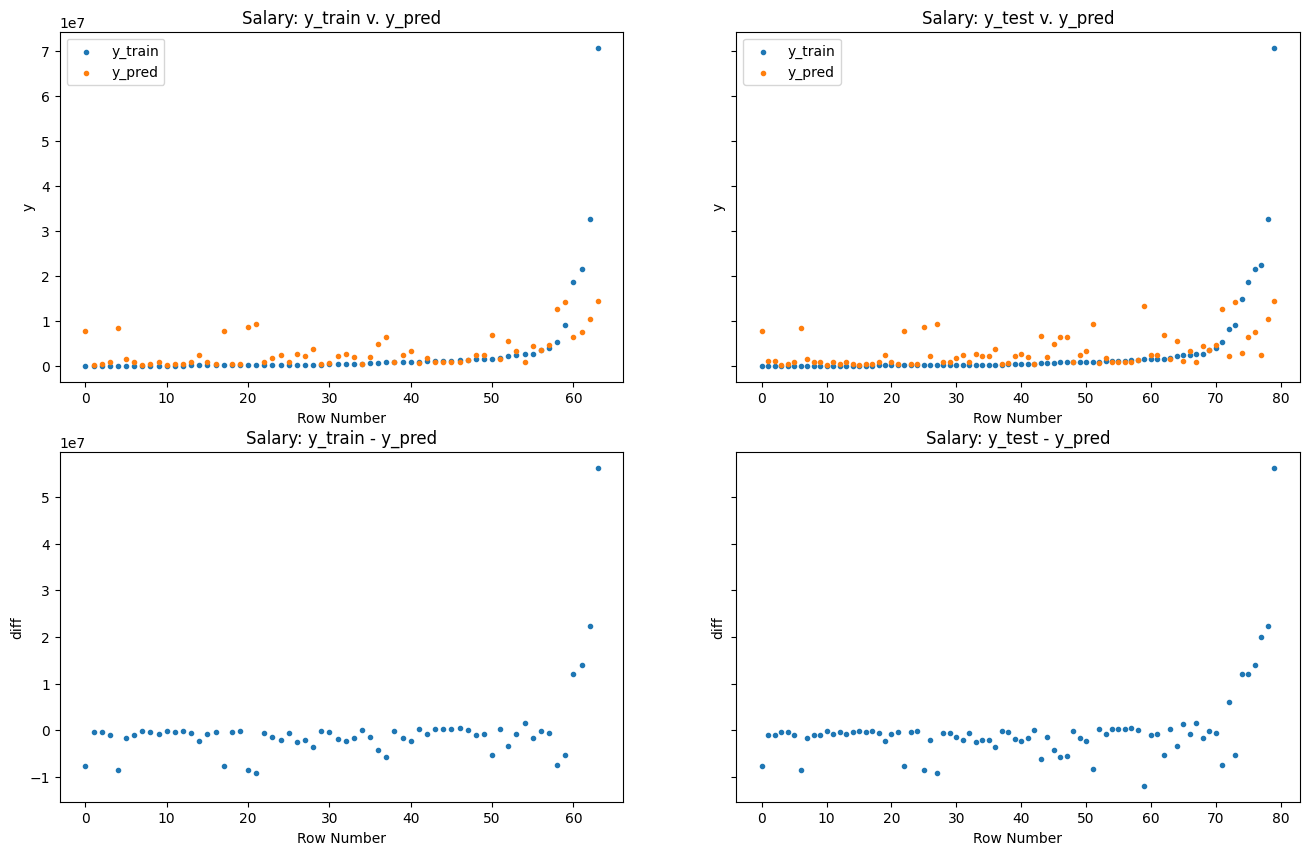

In [125]:
# df with real and predicted y for the train set
from matplotlib import pyplot as plt


y_pred_train = best_model.predict(X_train)
df_train = {'y_train': y_train, 'y_pred_train': y_pred_train, 'train_diff': y_train-y_pred_train}
df_train = pd.DataFrame(df_train)
df_train.sort_values(by = 'y_train', inplace = True)

# df with real and predicted y for the test set
y_pred_test = best_model.predict(X_test)
df_test = {'y_test': y_test, 'y_pred_test': y_pred_test, 'test_diff': y_test-y_pred_test}
df_test = pd.DataFrame(df_test)
df_test.sort_values(by = 'y_test', inplace = True)

# plot
figure, axis = plt.subplots(2, 2, figsize=(16, 10), sharey = 'row')

length_train = range(len(df_train))
length_test = range(len(df_test))

# Salary: y_train v. y_pred
axis[0, 0].scatter(length_train, df_train['y_train'], marker = '.', label = 'y_train')
axis[0, 0].scatter(length_train, df_train['y_pred_train'], marker = '.', label = 'y_pred')
axis[0, 0].legend()
axis[0, 0].set_title("Salary: y_train v. y_pred")
axis[0, 0].set_xlabel('Row Number')
axis[0, 0].set_ylabel('y')

# Salary: y_train - y_pred
axis[1, 0].scatter(length_train, df_train['train_diff'], marker = '.')
axis[1, 0].set_title("Salary: y_train - y_pred")
axis[1, 0].set_xlabel('Row Number')
axis[1, 0].set_ylabel('diff')

# Salary: y_test v. y_pred
axis[0, 1].scatter(length_test, df_test['y_test'], marker = '.', label = 'y_train')
axis[0, 1].scatter(length_test, df_test['y_pred_test'], marker = '.', label = 'y_pred')
axis[0, 1].legend()
axis[0, 1].set_title("Salary: y_test v. y_pred")
axis[0, 1].set_xlabel('Row Number')
axis[0, 1].set_ylabel('y')

# Salary: y_test - y_pred
axis[1, 1].scatter(length_test, df_test['test_diff'], marker = '.')
axis[1, 1].set_title("Salary: y_test - y_pred")
axis[1, 1].set_xlabel('Row Number')
axis[1, 1].set_ylabel('diff')

plt.show()